# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [16]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm, bernoulli, multinomial
from collections import defaultdict

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [17]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def __init__(self):
        self.mean = 0.0
        self.std = 1.0

    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        self.mean, self.std = norm.fit(X)
        if self.std < 1e-6:
            self.std = 1e-6

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        return norm.logpdf(X_new, self.mean, self.std)
        

# Distribution for binary features
class BinFeatureParam:
    def __init__(self):
        self.p = 0.0    
        
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        self.p = (sum(X) + ALPHA) / (len(X) + 2 * ALPHA)

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        return bernoulli.logpmf(X_new, self.p)

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # Count occurrences of each category in the data
        counts = np.zeros(self._num_of_categories)
        unique_elements, counts[unique_elements] = np.unique(X, return_counts=True)

        # Estimate probabilities for each category in the Multinoulli distribution
        total_samples = len(X)
        self.p = (counts + ALPHA) / (total_samples + self._num_of_categories * ALPHA)
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        return [np.log(self.p[X_new[i]]) for i in range(len(X_new))]
        #return multinomial.logpmf(X_new, sum(X_new), self.p)

**Tests:**
    
We will use the code below to test the correctness of your code.

In [18]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [19]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [20]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.9459101490553135, -2.169053700369523, -1.9459101490553135, -2.456735772821304, -2.169053700369523, -2.8622008809294686, -1.9459101490553135, -3.5553480614894135, -2.169053700369523, -2.8622008809294686]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [21]:
# Your task is to implement the three functions of NBC. 
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        # TODO: 
        # store the feature types
        self.feature_types = feature_types
        
        # boolean array indicating which features are categorical
        self.cat_feature = np.array([feature_types[n] == 'c' for n in range(len(feature_types))])

        # we store a list of classifiers
        self.classifiers = defaultdict()

        # initialization of the classificator on the basis of the feature types:
        for n in range(len(feature_types)):
            if feature_types[n] == 'r':
                self.classifiers[n] = defaultdict(ContFeatureParam)
            if feature_types[n] == 'b':
                self.classifiers[n] = defaultdict(BinFeatureParam)
            if feature_types[n] == 'c':
                self.classifiers[n] = defaultdict(CatFeatureParam, num_of_categories = 0)

        self.class_probabilities = defaultdict(int)
        

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        classes = np.unique(y)
        for cls in classes:
            X_cls = X[y == cls]
            self.class_probabilities[cls] = len(X_cls) / len(y)
            for n in range(X.shape[1]):
                if self.cat_feature[n]:
                    self.classifiers[n][cls] = CatFeatureParam(num_of_categories = np.max(X[:, n]) + 1)
                self.classifiers[n][cls].estimate(X_cls[:, n])
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO:
        # compute the log probability for each class
        log_prob = np.zeros([len(X), len(self.class_probabilities)])
        for cls in self.class_probabilities:
            log_prob[:, cls] = np.log(self.class_probabilities[cls])
            for n in range(X.shape[1]):
                log_prob[:, cls] += self.classifiers[n][cls].get_log_probability(X[:, n])
        # return the class with the highest log probability
        return np.argmax(log_prob, axis=1)


**Tests**

We will use the code below to check your code.

In [22]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [23]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [24]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [25]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [26]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=1000, num_splits=10):
    
    tst_errs_nbc = np.zeros(num_splits)
    tst_errs_lr = np.zeros(num_splits)

    N = X.shape[0]

    for r in range(num_runs):

        good_train_cat = True
        good_train_bin = True

        idx = np.random.permutation(N)
        Ntrain = int(0.8 * N)
        Xtrain = X[idx[:Ntrain]]
        ytrain = y[idx[:Ntrain]]
        Xtest = X[idx[Ntrain:]]
        ytest = y[idx[Ntrain:]]

        for i in range(len(nbc.feature_types)):
            if nbc.feature_types[i] == 'c':
                # note that we are going to subset the training set, thus the categories need to be present also in the 
                # first 10% of the training set
                unique_categories_train = np.unique(Xtrain[:int(0.1*Ntrain), i])
                unique_categories_test = np.unique(Xtest[:, i])
                test = [unique_categories_test[i] in unique_categories_train for i in range(len(unique_categories_test))]
                if False in test:
                    good_train_cat = False
                    continue

            if nbc.feature_types[i] == 'b':
                unique_categories_train = np.unique(Xtrain[:int(0.1*Ntrain), i])
                if 0 not in unique_categories_train or 1 not in unique_categories_train:
                    good_train_bin = False
                    continue
        
        # check whether all categories in the test set are present in the training set
        # if not, reshuffle the training set
        while good_train_cat == False or good_train_bin == False:
            idx = np.random.permutation(N)
            Ntrain = int(0.8 * N)
            Xtrain = X[idx[:Ntrain]]
            ytrain = y[idx[:Ntrain]]
            Xtest = X[idx[Ntrain:]]
            ytest = y[idx[Ntrain:]]

            good_train_cat = True
            good_train_bin = True

            for i in range(len(nbc.feature_types)):
                if nbc.feature_types[i] == 'c':
                    # note that we are going to subset the training set, thus the categories need to be present also in the 
                    # first 10% of the training set
                    unique_categories_train = np.unique(Xtrain[:int(0.1*Ntrain), i])
                    unique_categories_test = np.unique(Xtest[:, i])
                    test = [unique_categories_test[i] in unique_categories_train for i in range(len(unique_categories_test))]
                    if False in test:
                        good_train_cat = False
                        break

                if nbc.feature_types[i] == 'b':
                    unique_categories_train = np.unique(Xtrain[:int(0.1*Ntrain), i])
                    if 0 not in unique_categories_train or 1 not in unique_categories_train:
                        good_train_bin = False
                        break

        # standardize the continuous features to improve stability
        for i in range(len(nbc.feature_types)):
            if nbc.feature_types[i] == 'r':
                scaler = StandardScaler()
                scaler.fit(Xtrain[:, i].reshape(-1, 1))
                Xtrain[:,i] = scaler.transform(Xtrain[:,i].reshape(-1, 1)).reshape(-1)  
                Xtest[:,i] = scaler.transform(Xtest[:,i].reshape(-1, 1)).reshape(-1)

        for n in range(num_splits):
            Ntrain_n = int((n+1)*0.1*Ntrain)

            # fit the NBC and the LR on the first Ntrain_n samples
            nbc.fit(Xtrain[:Ntrain_n], ytrain[:Ntrain_n])
            lr.fit(Xtrain[:Ntrain_n], ytrain[:Ntrain_n])

            # compute the test errors
            yhat = nbc.predict(Xtest)
            tst_errs_nbc[n] += np.mean(yhat != ytest)

            yhat = lr.predict(Xtest)
            tst_errs_lr[n] += np.mean(yhat != ytest)

    # average the test errors across the runs
    tst_errs_nbc /= num_runs
    tst_errs_lr /= num_runs
    
    return tst_errs_nbc, tst_errs_lr

In [27]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. Prepare the data for the two classifiers, e.g., handle missing values and the categorical data. When you handle the categorical data, you should check whether the data is ordinal or not. If the data is ordinal, you should encode the data as integers. If the data is not ordinal, you should encode the data as one-hot vectors.
2. Show the first 5 rows of the prepared data
3. Compare the two classifiers on the dataset and generate the plots

The grading will be based on whether the data is correctly prepared and the plots are generated without errors. The grading will not be based on the performance of the classifiers and whether the plots are the same as in the paper. 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB
No missing values


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


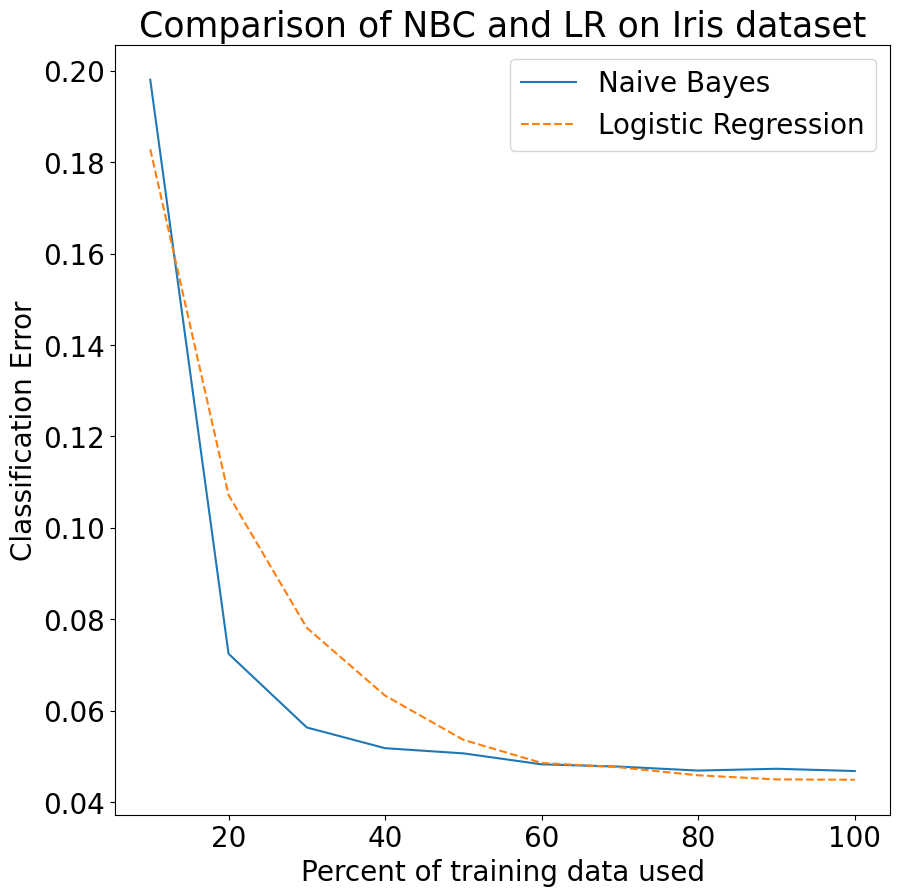

In [28]:
# TODO: insert your code for experiments
from sklearn.datasets import load_iris
iris = load_iris()

X, y = iris['data'], iris['target']
X_df = pd.DataFrame(X, columns=iris.feature_names)
X_df.info()

if X_df.isna().sum().all() == 0:
    print('No missing values')

# All features of the iris dataset are continuous.
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(random_state=0)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_iris, lr, X, y)
makePlot(tst_errs_nbc, tst_errs_lr, title='Comparison of NBC and LR on Iris dataset')

print(X_df.head())

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

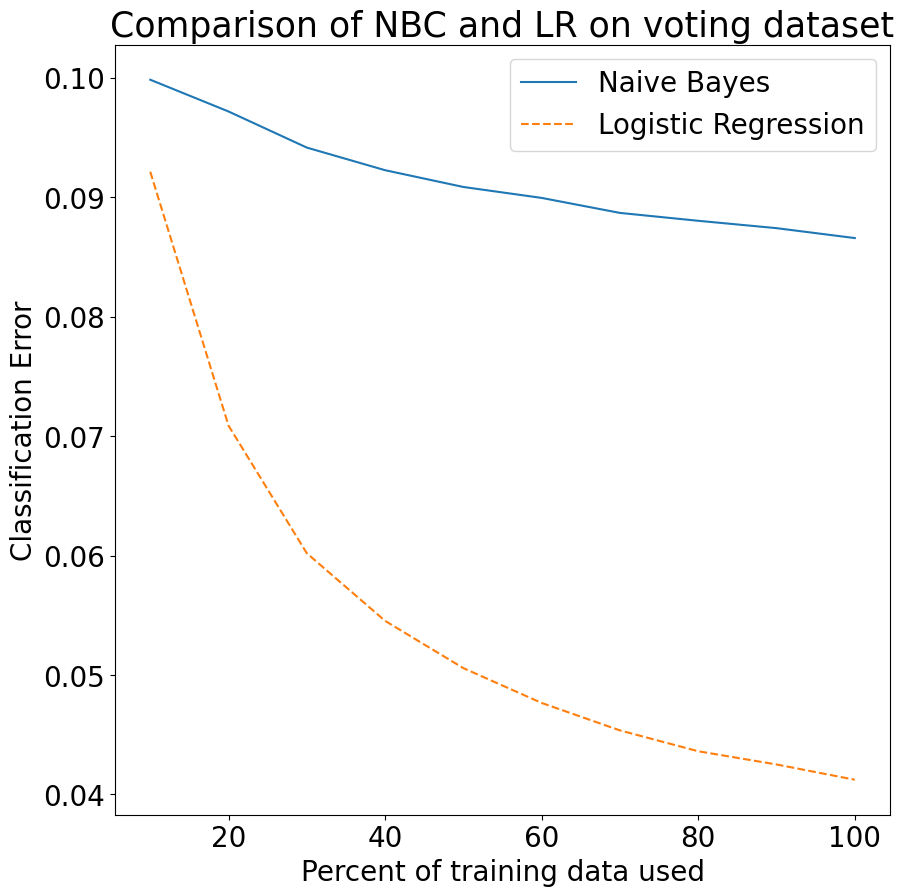

In [29]:
# load the dataset
# TODO: insert your code for experiments
voting = pd.read_csv('./datasets/voting.csv')

voting.info()

y = voting['label']
X = voting.iloc[:, 1:]

# drop the missing values
X = X.dropna()
y = y[X.index]

print(X.shape)

# we encode the features as binary features
X = X.replace({'n': 0, 'y': 1}).astype(int)
y = y.replace({'republican': 1, 'democrat': 0}).astype(int)
print(X.head())

X = X.values
y = y.values

# All features of this dataset are binary

nbc = NBC(feature_types=['b'] * X.shape[1])
lr = LogisticRegression(random_state=0)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y)
makePlot(tst_errs_nbc, tst_errs_lr, title='Comparison of NBC and LR on voting dataset')

**Dataset 3: Breast Cancer Dataset (Bonus Tasks)**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

The dataset has continues, binary and categorical features. It also has missing values.

Hints: You can precompute the size of the domains of the categorical features.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB
                  Class    age menopause tumor-size inv-nodes node-caps  \
0  no-recurrence-events  30-39   premeno      30-34       0-2        no   
1  no-recurrence-events  40-49   premeno      20-24       0-2        no   
2  no-recurrence-events  40-49   premeno      20-24       0-2        no   
3  no-recurrence-events  60-69      ge40      15-19 

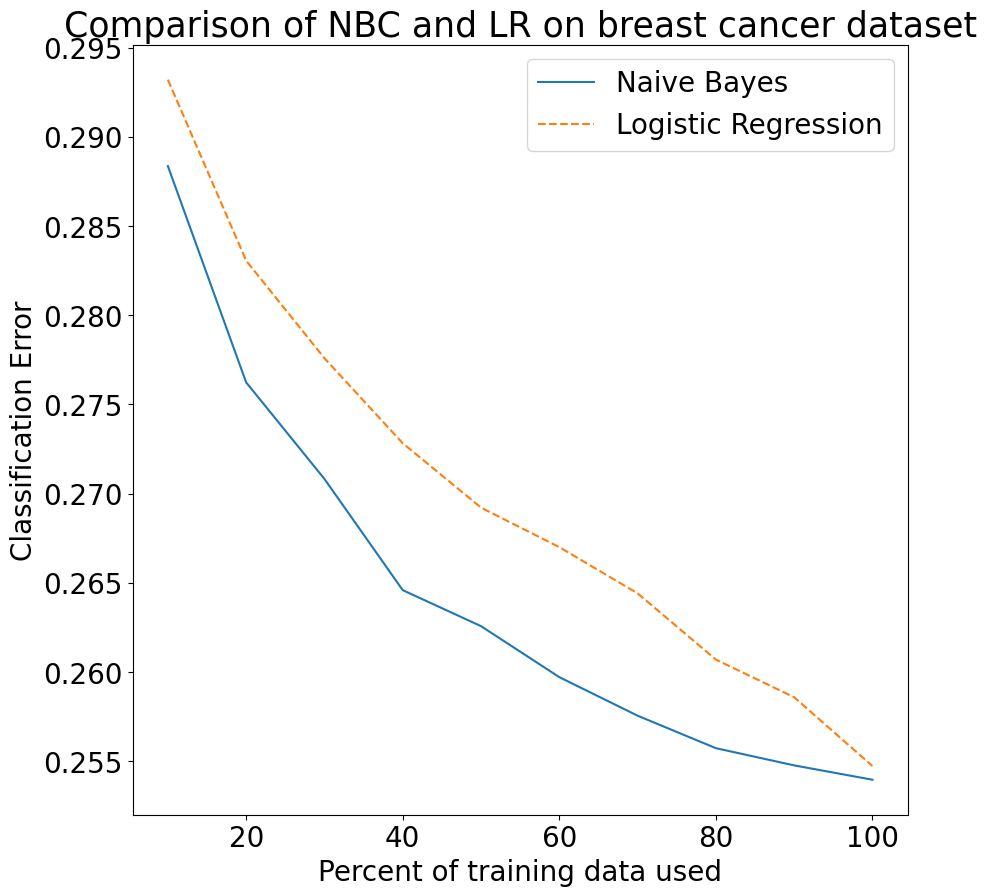

In [30]:
# load the dataset
# TODO: insert your code for experiments
cancer = pd.read_csv('./datasets/breast-cancer.csv')

cancer.info()
print(cancer.head())

y = cancer['Class']
X = cancer.iloc[:, 1:]

# drop the missing values
X = X.dropna()
y = y[X.index]

# Remove rows containing '?' across all columns
X = X[X.ne('?').all(axis=1)]
y = y[X.index]

X.reset_index(drop=True, inplace=True)

# target values are binary
y = y.replace({'no-recurrence-events': 0, 'recurrence-events': 1}).astype(int)
# features 5, 7 and 9 are binary, features 1, 2, 3, 4, 6, 8 are categorical
X['node-caps'] = X['node-caps'].replace({'no': 0, 'yes': 1}).astype(int)
X['breast'] = X['breast'].replace({'right': 0, 'left': 1}).astype(int)
X['irradiat'] = X['irradiat'].replace({'no': 0, 'yes': 1}).astype(int)

# as far as it concerns the categorical features, we need to encode them. If the categories have a natural order, we can use an ordinal encoder, 
# otherwise we need to use a one-hot encoder
age_categories = [np.unique(X['age'])]
age_ordinal_encoder = OrdinalEncoder(categories=age_categories)
X['age'] = age_ordinal_encoder.fit_transform(X[['age']]).astype(int)

one_hot_encoder = OneHotEncoder(drop='first') # drop='first' to avoid dummy variable trap
menopause_encoded = one_hot_encoder.fit_transform(X[['menopause']]).astype(int)
menopause_encoded_df = pd.DataFrame(menopause_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(['menopause']))

tumor_size_categories = [np.unique(X['tumor-size'])]
tumor_size_ordinal_encoder = OrdinalEncoder(categories=tumor_size_categories)
X['tumor-size'] = tumor_size_ordinal_encoder.fit_transform(X[['tumor-size']]).astype(int)

inv_nodes_categories = [np.unique(X['inv-nodes'])]
inv_nodes_ordinal_encoder = OrdinalEncoder(categories=inv_nodes_categories)
X['inv-nodes'] = inv_nodes_ordinal_encoder.fit_transform(X[['inv-nodes']]).astype(int)

deg_malig_categories = [np.unique(X['deg-malig'])]
deg_malig_ordinal_encoder = OrdinalEncoder(categories=deg_malig_categories)
X['deg-malig'] = deg_malig_ordinal_encoder.fit_transform(X[['deg-malig']]).astype(int)

breast_quad_encoded = one_hot_encoder.fit_transform(X[['breast-quad']]).astype(int)
breast_quad_encoded_df = pd.DataFrame(breast_quad_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(['breast-quad']))

X = pd.concat([X, menopause_encoded_df, breast_quad_encoded_df, ], axis=1).drop(['menopause', 'breast-quad'], axis=1)
print(X.head())
X = X.values.astype(int)
y = y.values.astype(int)

print(X.shape)

# define a vector containing the types of the features
feature_types = ['c'] * 3 + ['b'] + ['c'] + ['b'] * 8

nbc = NBC(feature_types=feature_types)
lr = LogisticRegression(random_state=0)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y)
makePlot(tst_errs_nbc, tst_errs_lr, title='Comparison of NBC and LR on breast cancer dataset')
